### Exercise 01

## Exercise 01.1

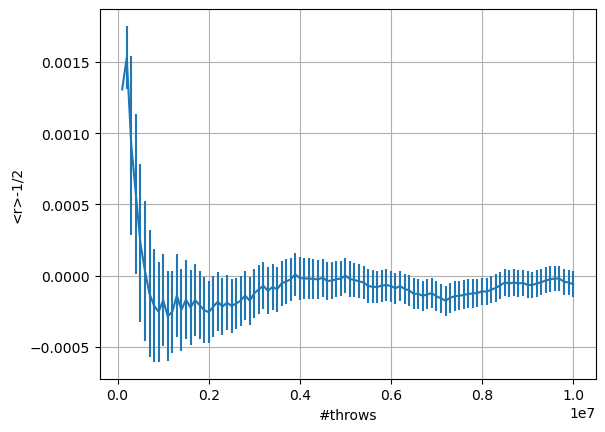

In [7]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np

n_throws, cum_avg, block_error = np.loadtxt("../data/ex_01.1a.dat", unpack=True, usecols=(0,1,2))

plt.errorbar(n_throws, cum_avg-0.5, yerr=block_error)
plt.xlabel('#throws')
plt.ylabel('<r>-1/2')
plt.grid(True)
plt.show()

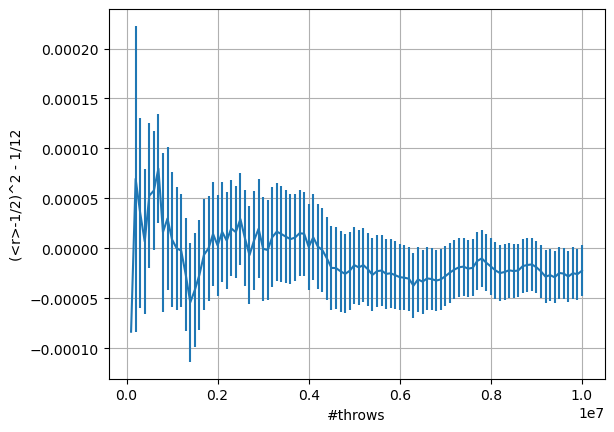

In [8]:
import math

vn_throws, vcum_avg, vblock_error = np.loadtxt("../data/ex_01.1b.dat", unpack=True, usecols=(0,1,2))

plt.errorbar(vn_throws, vcum_avg-1/12, yerr=vblock_error)
plt.xlabel('#throws')
plt.ylabel('(<r>-1/2)^2 - 1/12')
plt.grid(True)
plt.show()